In [6]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy import constants
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support
from tqdm import tqdm

In [7]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('..')

In [9]:

from photutils.psf import IntegratedGaussianPRF, PSFPhotometry
from photutils.detection import DAOStarFinder
from photutils import CircularAperture
from photutils.background import MMMBackground, LocalBackground


from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, chrDistAng
import globals

from config import *


(3000.0, 10000.0)

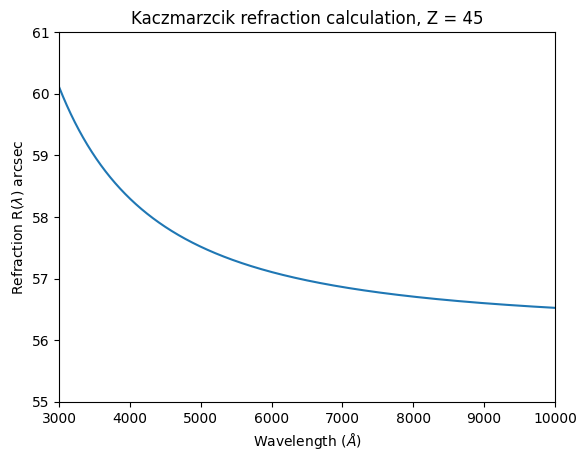

In [5]:
#plt.plot(np.arange(3000, 10000), R(l = np.arange(3000, 10000), Z = 45))
plt.plot(np.arange(3000, 10000), dcr_offset(w_eff=np.arange(3000, 10000), airmass= 1 / np.cos(np.deg2rad(45))))
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Refraction R($\lambda$) arcsec')
plt.title('Kaczmarzcik refraction calculation, Z = 45')
plt.ylim(55,61)
plt.xlim(3000, 10000)

In [6]:
#PARAMS
flare_ref_pos = np.array([323.0, 429.5])

filters = ['u', 'g', 'r', 'i', 'z', 'y']

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

In [ ]:
hdu_list = fits.open('dwfflare/0a7936112f3150350b27277900f88de2_c4d_151218_061807_ooi_g_v1.fits.fz')
hdu_list.info()

Filename: /Users/riley/Desktop/RAFTS/dwfflare/0a7936112f3150350b27277900f88de2_c4d_151218_061807_ooi_g_v1.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   ()      
  1  S29           1 CompImageHDU    129   (2046, 4094)   float32   
  2  S31           1 CompImageHDU    129   (2046, 4094)   float32   
  3  S25           1 CompImageHDU    129   (2046, 4094)   float32   
  4  S26           1 CompImageHDU    129   (2046, 4094)   float32   
  5  S27           1 CompImageHDU    129   (2046, 4094)   float32   
  6  S28           1 CompImageHDU    129   (2046, 4094)   float32   
  7  S20           1 CompImageHDU    129   (2046, 4094)   float32   
  8  S21           1 CompImageHDU    129   (2046, 4094)   float32   
  9  S22           1 CompImageHDU    129   (2046, 4094)   float32   
 10  S23           1 CompImageHDU    129   (2046, 4094)   float32   
 11  S24           1 CompImageHDU    129   (2046, 4094)   float32   
 12  S14      

In [8]:
imnames = np.array(os.listdir('dwfflare'))

In [ ]:
#Collect DATE-OBS list
datelist = []

for i, imname in enumerate(imnames):
    try:
        image_header = fits.getheader('dwfflare/' + imname, ext=0)
        datelist.append(image_header['DATE-OBS'])

    except:
        print(i, 'EXT not found')
        datelist.append(image_header['DATE-OBS'])

datearr = np.array(datelist)

44 EXT not found
129 EXT not found


In [ ]:
#Find .fits files that are missing S18 extension
badinds = []

for i, imname in enumerate(imnames):
    try:
        image_data = fits.getheader('dwfflare/' + imname, ext=16)

    except:
        print(i, 'EXT not found')
        badinds.append(i)

badinds = np.array(badinds)

36 EXT not found
40 EXT not found
44 EXT not found
59 EXT not found
129 EXT not found
141 EXT not found
165 EXT not found
215 EXT not found
244 EXT not found
285 EXT not found
288 EXT not found


In [11]:
mask = np.ones(len(imnames), dtype=int)
mask[badinds] = 0
mask = mask > 0
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [65]:
imnames_timeordered = imnames[mask][np.argsort(datearr[mask])]
np.save('Outdata/imnames_timeordered.npy', imnames_timeordered)

In [ ]:
times = []

for imname in imnames_timeordered:
    imname = imname[:-8] + '_S18' + imname[-8:]
    file = 'dwfflare/dwfflareS18/' + imname 
    header = fits.getheader('dwfflare/dwfflareS18/' + imname)
    time = Time(header['DATE-OBS'])
    times.append(time)

times, len(times)

([<Time object: scale='utc' format='isot' value=2015-12-18T05:38:27.285>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:39:16.701>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:41:44.705>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:42:32.908>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:43:20.630>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:44:08.956>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:44:57.216>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:45:46.128>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:46:32.997>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:47:21.185>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:48:09.130>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:48:57.103>,
  <Time object: scale='utc' format='isot' value=2015-12-18T05:49:44.621>,
  <Time object: scale='utc' format='is

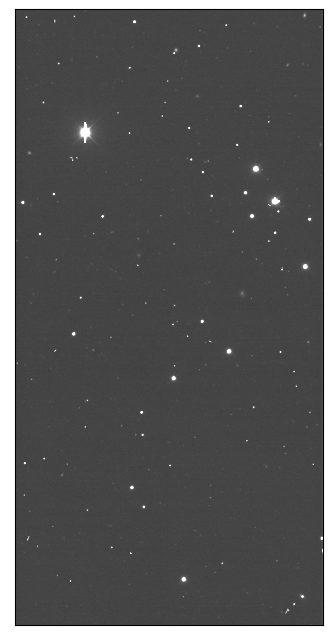

In [ ]:
#Look at a single img
imname = imnames_timeordered[0]
imname = imname[:-8] + '_S18' + imname[-8:]
file = 'dwfflare/dwfflareS18/' + imname 
data = fits.getdata('dwfflare/dwfflareS18/' + imname)
header = fits.getheader('dwfflare/dwfflareS18/' + imname)
wcs = WCS(header)
time = Time(header['DATE-OBS'])

plt.figure(figsize=(16,8))
plt.imshow(data, cmap='Greys_r', clim=(0,100))
plt.xticks([])
plt.yticks([]);

Img 0


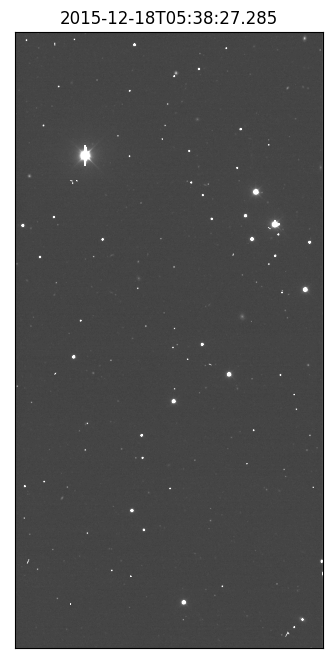

Img 1


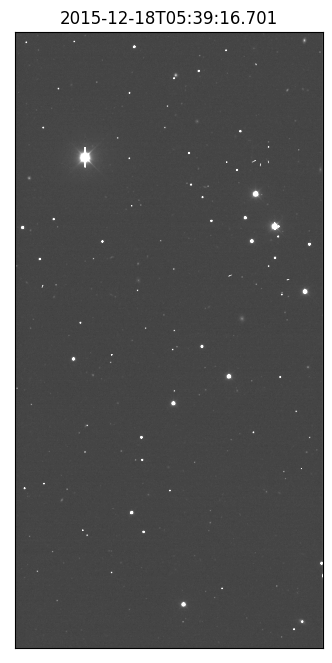

Img 2


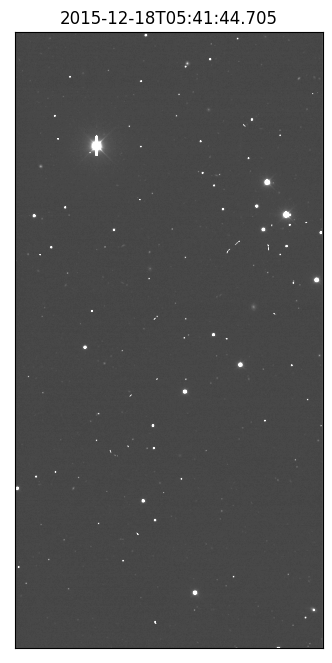

Img 3


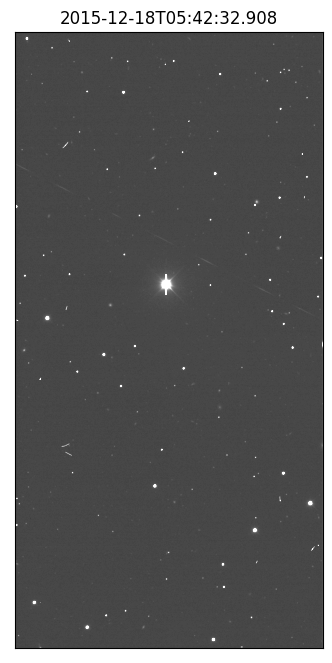

Img 4


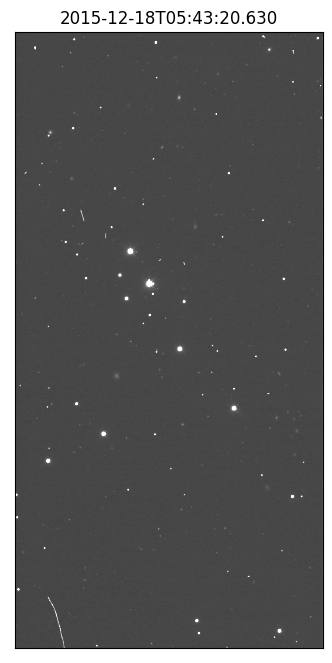

Img 5


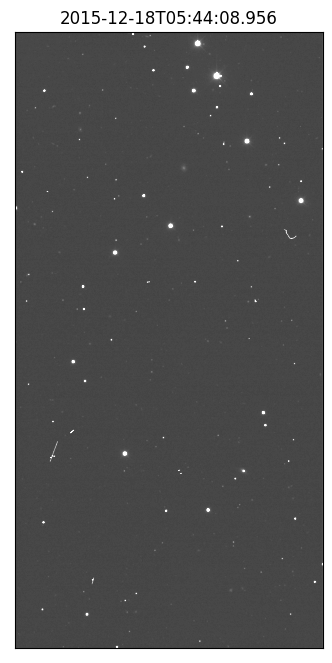

Img 6


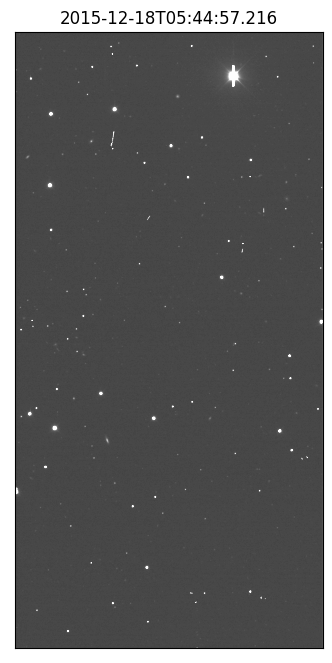

Img 7


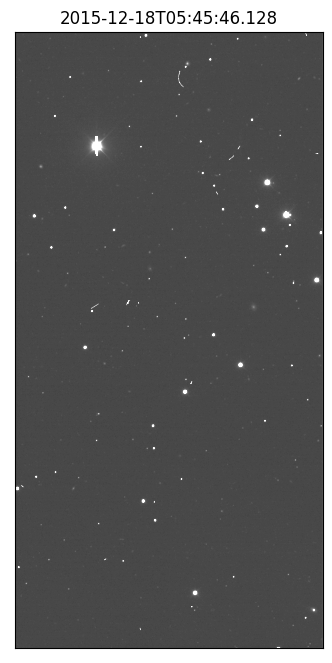

Img 8


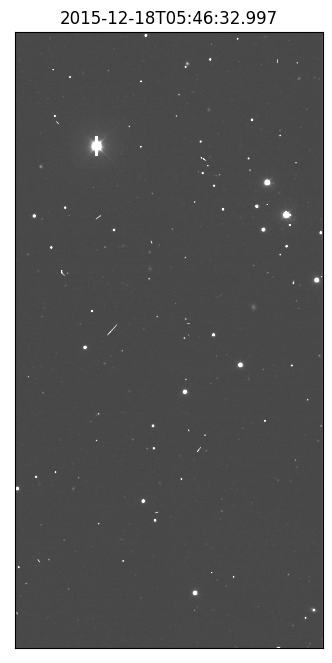

Img 9


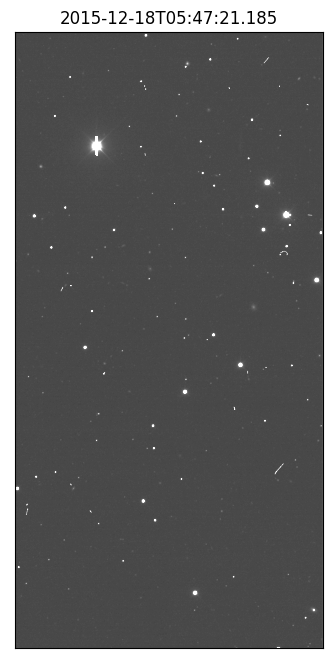

In [ ]:
#Look at first 10 imgs
for i, imname in enumerate(imnames_timeordered[:10]):
    imname = imname[:-8] + '_S18' + imname[-8:]
    file = 'dwfflare/dwfflareS18/' + imname 
    data = fits.getdata('dwfflare/dwfflareS18/' + imname)
    header = fits.getheader('dwfflare/dwfflareS18/' + imname)
    wcs = WCS(header)
    time = Time(header['DATE-OBS'])

    print('Img {}'.format(i))
    plt.figure(figsize=(16,8))
    plt.imshow(data, cmap='Greys_r', clim=(0,100))
    plt.title('{}'.format(time))
    plt.xticks([])
    plt.yticks([])
    plt.show()

## PSF Fitting

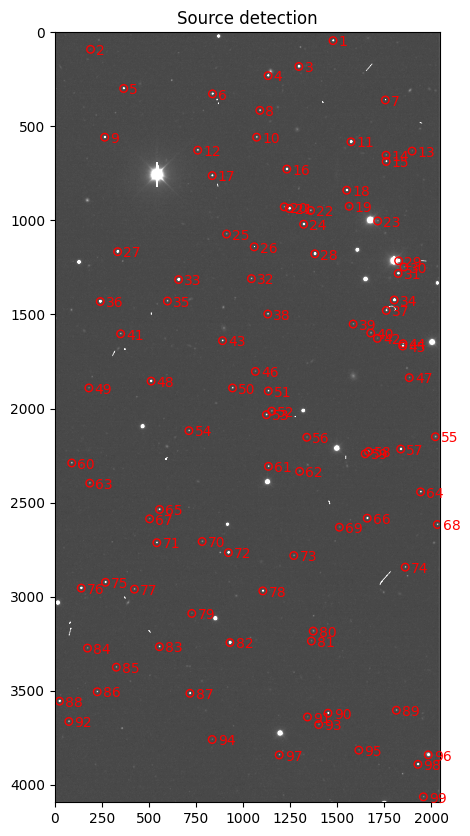

<QTable length=99>
  id  group_id     local_bkg      ...         cfit         flags
int64  int64        float64       ...       float64        int64
----- -------- ------------------ ... -------------------- -----
    1        1 25.326652965139836 ... 0.019392958333000327     0
    2        2 22.549654121072884 ...  0.18756121907057616     0
    3        3 26.819340355038022 ... 0.019271281231501503     0
    4        4 26.018112402695877 ...  0.01944031535375164     0
    5        5 26.202015463374714 ...  0.01979344400127595     0
    6        6 25.386566686016295 ...  0.01950605794934803     0
    7        7 22.837959063255184 ...  0.08669142694246713     0
    8        8 24.166961223521135 ...  0.02156389386803109     0
    9        9  25.65434655008862 ... 0.017893036172781353     0
   10       10  24.43263715000476 ... 0.022715873730539234     0
  ...      ...                ... ...                  ...   ...
   90       90  24.24333201841111 ...  0.02147788504215853     0
   91       91 22.772221536595424 ... 0.011945927023978417     0
   92       92  23.51227971514919 ...  0.01885031727662557     0
   93       93 23.072555347199135 ... 0.021127599608502346     0
   94       94  22.77157131080464 ... 0.026355811688700378     0
   95       95 22.308547178227847 ... 0.017744818628330702     0
   96       96  43.28323494996263 ...  0.01960097835469163     0
   97       97 23.060043497288483 ... 0.018465348235189416     0
   98       98 24.445389542624213 ... 0.018661033395473044     0
   99       99 23.646746614794708 ... 0.022486877143451982     0

In [16]:
mmm_bkg = MMMBackground()
localbkg_estimator = LocalBackground(5, 10, mmm_bkg)

finder = DAOStarFinder(threshold=1*mmm_bkg(data), fwhm=header['FWHM'], roundlo=-0.3, roundhi=0.3, peakmax=4000, exclude_border=True)
sources = finder(data)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=20.)

plt.figure(figsize=(20,10))
plt.imshow(data, clim=(0,100), cmap='Greys_r')
apertures.plot(color='red')

for i, p in enumerate(positions):
    plt.annotate('{0}'.format(sources['id'][i]), xy=p, xytext=p+30, color='r')
plt.title('Source detection')
plt.show()

psf_model = IntegratedGaussianPRF(sigma=header['FWHM'])
fit_shape = (25, 25)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=5,
                        localbkg_estimator=localbkg_estimator)
phot = psfphot(data)
phot

## PSF Fitting Across Multiple Images

In [17]:
start = 8
end = 82

In [18]:
times = np.array([time.mjd for time in times[start:end]])

In [ ]:
plot = False
match_dist = 0.5
main_df = pd.DataFrame()

for i, imname in enumerate(imnames_timeordered[start:end]):
    print('{0}/{1}'.format(i+1, len(imnames_timeordered[start:end])))
    imnameS18 = imname[:-8] + '_S18' + imname[-8:]
    data = fits.getdata('dwfflare/dwfflareS18/' + imnameS18)
    header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
    exp_header = fits.getheader('dwfflare/' + imname)
    wcs = WCS(header)
    time = Time(header['DATE-OBS'])

    ##PSF Photometry
    mmm_bkg = MMMBackground()
    print('Background: {}'.format(mmm_bkg.calc_background(data)))
    print('Seeing: {}'.format(header['FWHM']))
    localbkg_estimator = LocalBackground(5, 10, mmm_bkg)
    finder = DAOStarFinder(threshold=1.0*mmm_bkg.calc_background(data), fwhm=header['FWHM'], roundlo=-0.4, roundhi=0.4, peakmax=10000, exclude_border=True)
    sources = finder(data)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=20.)
    psf_model = IntegratedGaussianPRF(sigma=header['FWHM'])
    fit_shape = (25, 25)
    psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=5,
                            localbkg_estimator=localbkg_estimator)
    phot = psfphot(data)
    
    out_df = phot.to_pandas().to_csv('Outdata/photdf_{}.csv'.format(i))
    pass

    #Create epochal dataframe, append to main_df
    if i == 0:
        ref_df = phot.to_pandas()
        ref_df['RA'] = wcs.all_pix2world(ref_df[['x_fit', 'y_fit']].values, 1)[:,0]
        ref_df['DEC'] = wcs.all_pix2world(ref_df[['x_fit', 'y_fit']].values, 1)[:,1]
        ref_df['RA_ERR'] = np.abs( wcs.all_pix2world(ref_df[['x_fit', 'y_fit']].values + ref_df[['x_err', 'y_err']].values, 1)[:,0] - ref_df['RA'].values )
        ref_df['DEC_ERR'] = np.abs( wcs.all_pix2world(ref_df[['x_fit', 'y_fit']].values + ref_df[['x_err', 'y_err']].values, 1)[:,1] - ref_df['DEC'].values )
        ref_df['time'] = time.mjd
        main_df = main_df.append(ref_df)

    else:
        img_df = phot.to_pandas()
        img_df['RA'] = wcs.all_pix2world(img_df[['x_fit', 'y_fit']].values, 1)[:,0]
        img_df['DEC'] = wcs.all_pix2world(img_df[['x_fit', 'y_fit']].values, 1)[:,1]
        img_df['RA_ERR'] = np.abs( wcs.all_pix2world(img_df[['x_fit', 'y_fit']].values + img_df[['x_err', 'y_err']].values, 1)[:,0] - img_df['RA'].values )
        img_df['DEC_ERR'] = np.abs( wcs.all_pix2world(img_df[['x_fit', 'y_fit']].values + img_df[['x_err', 'y_err']].values, 1)[:,1] - img_df['DEC'].values )
        img_df['time'] = time.mjd

        #match rows in img_df to ref_df locations
        for index, row in img_df.iterrows():

            matches = (np.sqrt(( (row['RA'] - ref_df['RA']) * 3600 )**2 + ( (row['DEC'] - ref_df['DEC']) * 3600 )**2) < match_dist ).values

            if matches.any():

                img_df['id'].iloc[index] = ref_df['id'].loc[matches]

            else:
                img_df.iloc[index] = np.full(img_df.shape[1], np.nan)
        
        '''
        for index, row in ref_df.iterrows():

            matches = (np.sqrt(( (row['RA'] - img_df['RA']) * 3600 )**2 + ( (row['DEC'] - img_df['DEC']) * 3600 )**2) < match_dist ).values

            if matches.any():

                img_df['id'].iloc[matches] = ref_df['id'].loc[index]

            else:
                
                img_df.loc[index + 0.5] = np.full(img_df.shape[1], np.nan)
                img_df['id'].loc[index + 0.5] = ref_df['id'].loc[index]
                img_df = img_df.sort_index().reset_index(drop=True)
        '''
                
        main_df = main_df.append(img_df)

        if plot:
            plt.figure(figsize=(20,10))
            plt.imshow(data, clim=(0,100), cmap='Greys_r')
            
            plt.scatter(flare_ref_pos[0], flare_ref_pos[1], marker='s', s=200, edgecolors='white', facecolors='None')
            plt.scatter(ref_df['x_fit'], ref_df['y_fit'], facecolor='None', edgecolor='red', s=50)
            plt.scatter(img_df['x_fit'], img_df['y_fit'], color='blue', s=10)
            for i, row in img_df.iterrows():
                plt.annotate('{0}'.format(row['id']), xy=row[['x_fit', 'y_fit']], xytext=row[['x_fit', 'y_fit']]+50, color='blue')
            for i, row in ref_df.iterrows():
                plt.annotate('{0}'.format(row['id']), xy=row[['x_fit', 'y_fit']], xytext=row[['x_fit', 'y_fit']]-50, color='red')
            plt.title('{}'.format(time))
            plt.show()


1/74
Background: 22.61159896850586
Seeing: 4.43482
2/74
Background: 22.676097869873047
Seeing: 4.376634
3/74
Background: 22.601224899291992
Seeing: 4.276115
4/74
Background: 22.449626922607422
Seeing: 4.752764
5/74
Background: 22.213088989257812
Seeing: 4.462484
6/74
Background: 21.96426773071289
Seeing: 4.65583
7/74
Background: 21.819034576416016
Seeing: 4.43873
8/74
Background: 21.79634666442871
Seeing: 4.753464
9/74
Background: 21.881399154663086
Seeing: 4.500192
10/74
Background: 22.006439208984375
Seeing: 4.886186
11/74
Background: 22.193037033081055
Seeing: 4.728494
12/74
Background: 22.35736846923828
Seeing: 4.90379
13/74
Background: 22.470571517944336
Seeing: 4.694198
14/74
Background: 22.492992401123047
Seeing: 4.642942
15/74
Background: 22.451963424682617
Seeing: 4.747898
16/74
Background: 22.46060562133789
Seeing: 4.72095
17/74
Background: 22.460243225097656
Seeing: 4.83412
18/74
Background: 22.479530334472656
Seeing: 4.725427
19/74
Background: 22.614151000976562
Seeing: 5.1

In [11]:
main_df = main_df.sort_values('time')
main_df = main_df.dropna(how="all")

main_df.head()
main_df.to_csv('Outdata/main_df.csv', index=False)

In [13]:
flr_id = 11

What's the flare stars ID?

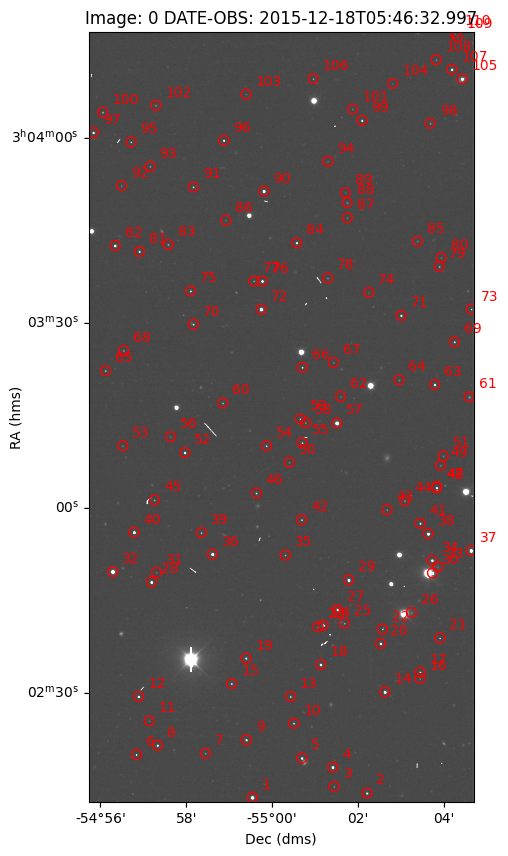

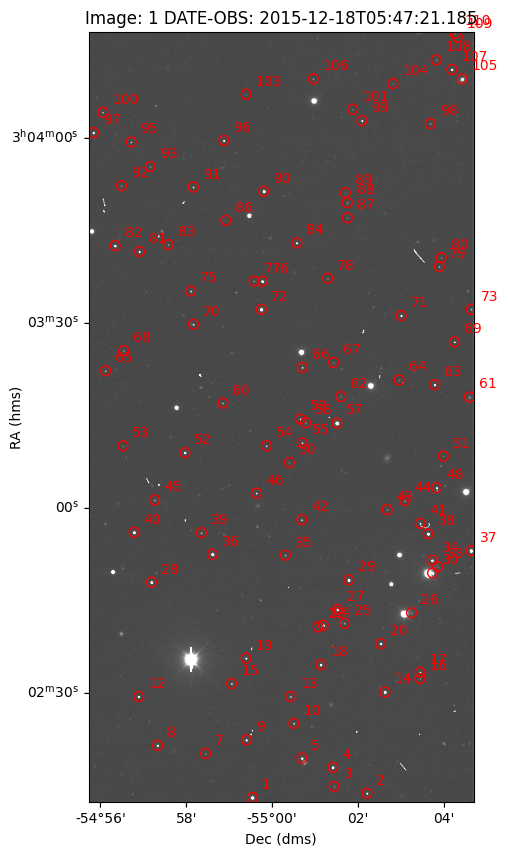

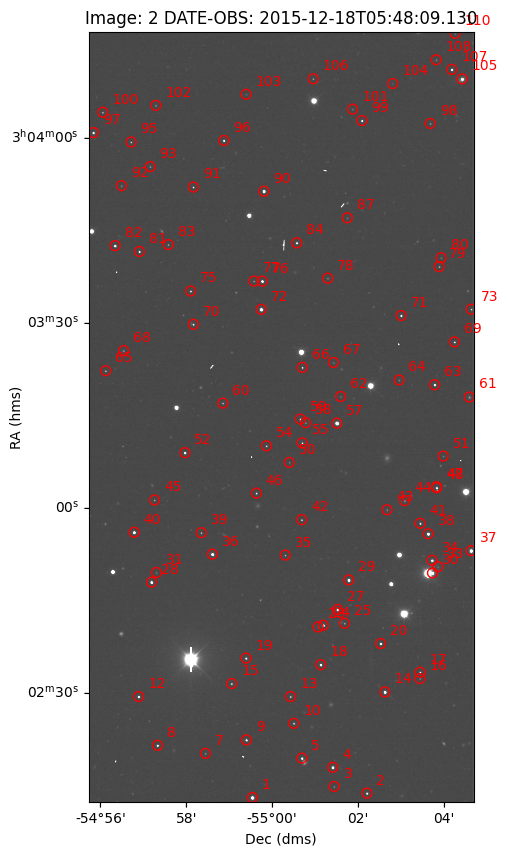

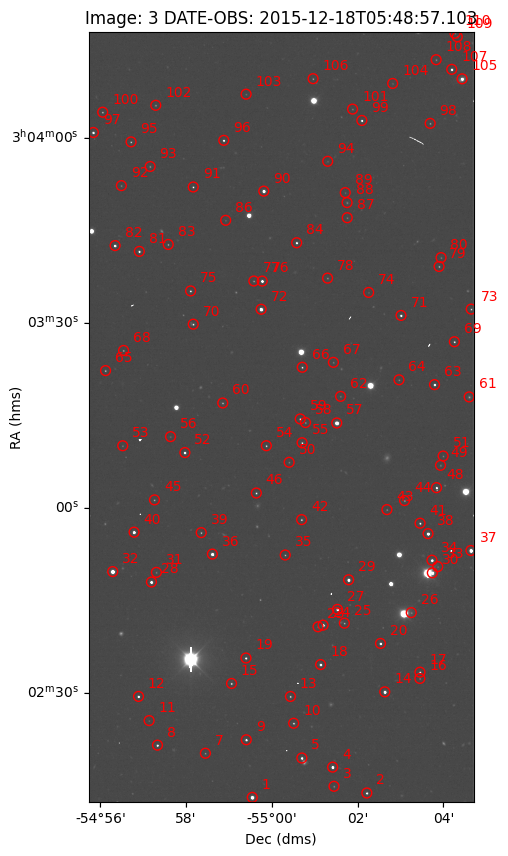

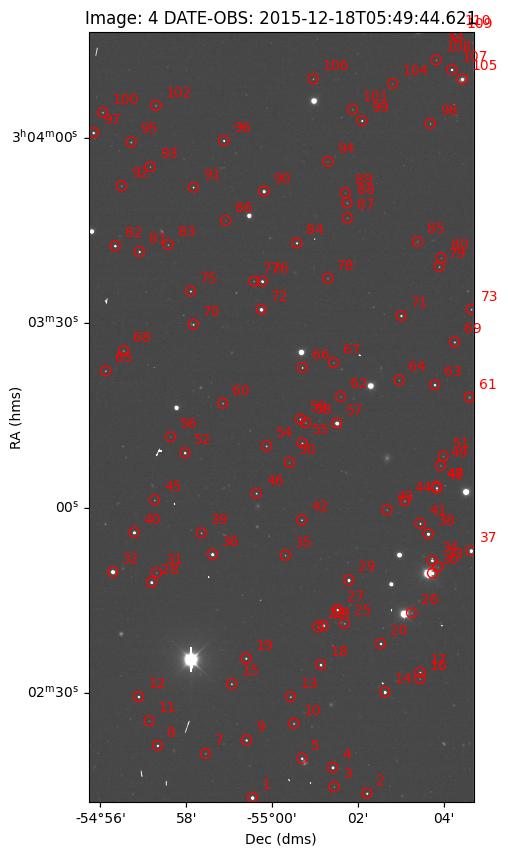

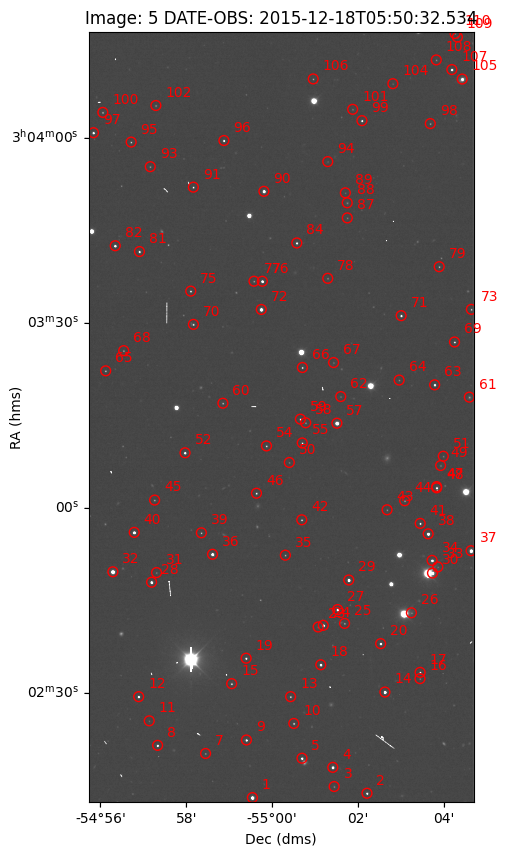

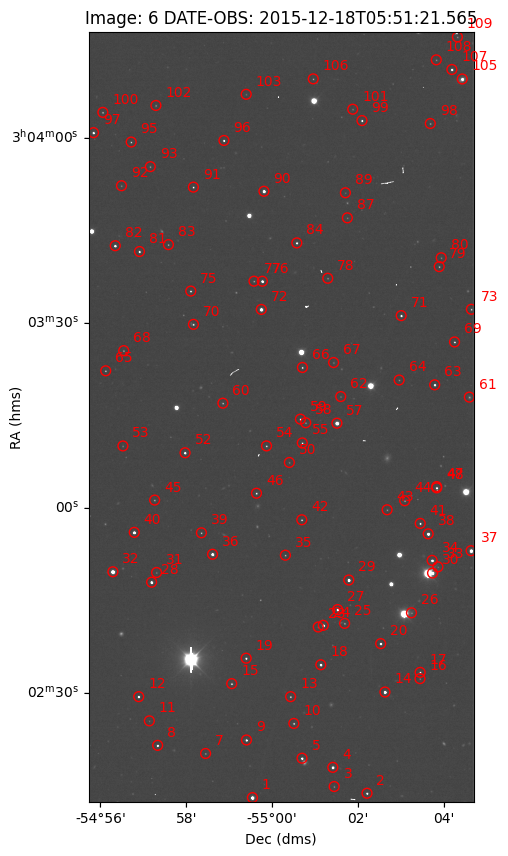

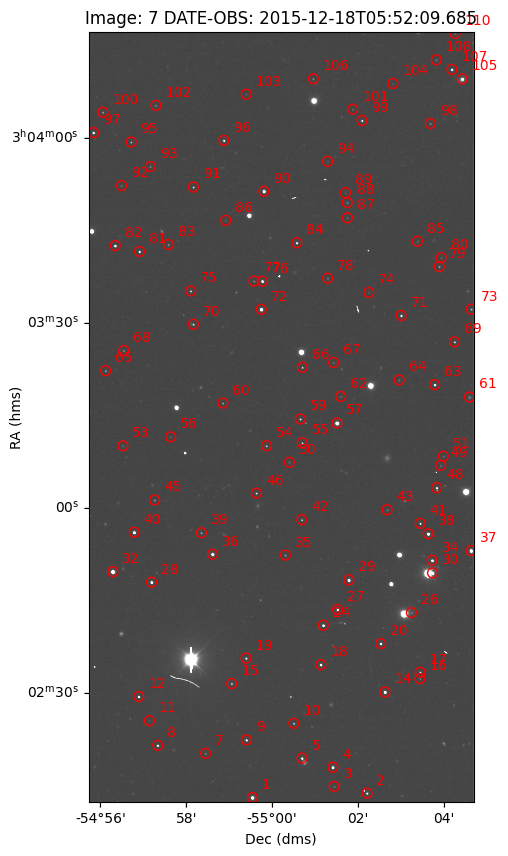

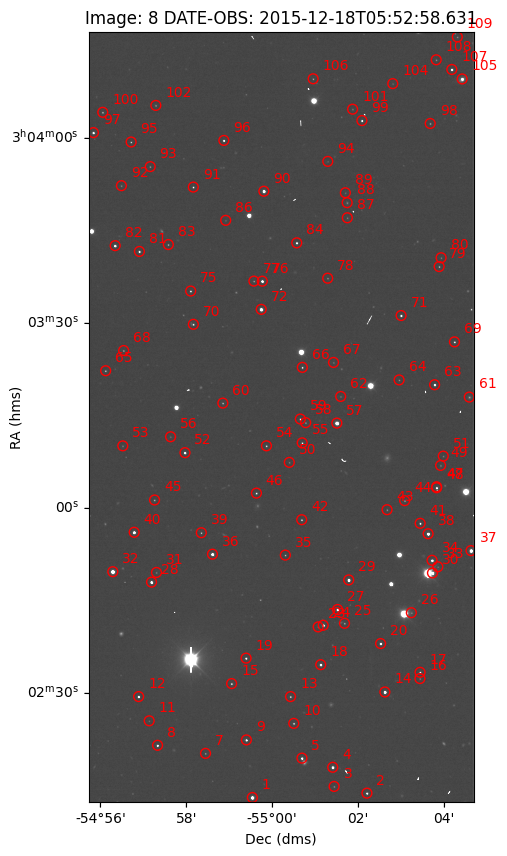

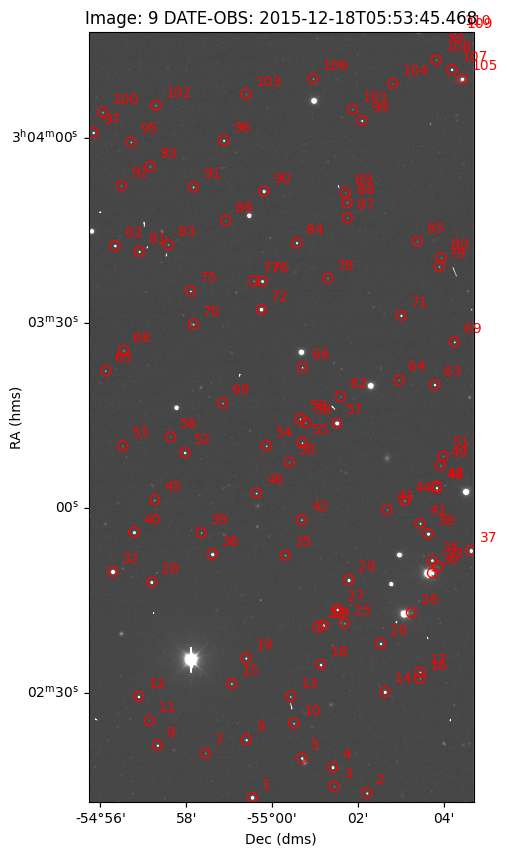

In [ ]:
for c, imname in enumerate(imnames_timeordered[start:start+10]):
    imnameS18 = imname[:-8] + '_S18' + imname[-8:]
    data = fits.getdata('dwfflare/dwfflareS18/' + imnameS18)
    header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
    exp_header = fits.getheader('dwfflare/' + imname)
    wcs = WCS(header)
    time = Time(header['DATE-OBS'])

    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': wcs})
    ax.imshow(data, clim=(0,100), cmap='Greys_r')
    #ax.scatter(flare_ref_pos[0], flare_ref_pos[1], marker='s', s=200, edgecolors='white', facecolors='None')
    ax.scatter(main_df['x_fit'][main_df['time'] == time.mjd], main_df['y_fit'][main_df['time'] == time.mjd], facecolor='None', edgecolor='red', s=50)

    for i, row in main_df[main_df['time'] == time.mjd].iterrows():
        ax.annotate('{0}'.format(int(row['id'])), xy=row[['x_fit', 'y_fit']], xytext=row[['x_fit', 'y_fit']]+50, color='red')

    ax.set_title('Image: {0} DATE-OBS: {1}'.format(c, time))

    lon, lat = ax.coords
    lon.set_ticks()
    lon.set_ticks_position('lb')
    lon.set_ticklabel_position('lb')
    lon.set_axislabel('Dec (dms)')
    lat.set_ticks()
    lat.set_ticks_position('lb')
    lat.set_ticklabel_position('lb')
    lat.set_axislabel('RA (hms)', minpad=-0.4)

    plt.show()

In [23]:
display(main_df[main_df['id'] == flr_id])

id  group_id  local_bkg      x_init      y_init    flux_init  \
10  11.0      11.0  23.205445  320.609651  428.992096  2376.580928   
10  11.0      11.0  22.622928  320.445774  429.464169  2314.052575   
12  11.0      13.0  21.484964  320.963110  428.407932  2389.650484   
12  11.0      13.0  22.801374  320.993946  428.131239  2308.515674   
11  11.0      12.0  22.459800  320.984981  428.186120  2306.726342   
..   ...       ...        ...         ...         ...          ...   
10  11.0      11.0  26.651665  320.227083  427.290883  3545.589688   
10  11.0      11.0  26.684314  320.357455  428.162025  3440.164793   
10  11.0      11.0  26.834987  319.850318  427.045720  3529.139337   
10  11.0      11.0  26.829193  319.657690  427.766516  3504.598482   
11  11.0      12.0  26.711660  318.718544  427.778942  3525.253244   

         x_fit       y_fit     flux_fit     x_err  ...  npixfit  group_size  \
10  320.632378  429.042347  1027.231919  0.360207  ...    625.0         1.0   
10  320.231374  429.698961  1011.509538  0.400446  ...    625.0         1.0   
12  320.817316  428.605051  1379.440040  0.279779  ...    625.0         1.0   
12  320.803206  428.441936   929.501917  0.440706  ...    625.0         1.0   
11  321.409020  428.272199  1019.880413  0.377237  ...    625.0         1.0   
..         ...         ...          ...       ...  ...      ...         ...   
10  320.243422  427.547101  2777.467436  0.335752  ...    625.0         1.0   
10  320.296185  428.493803  2725.231354  0.343860  ...    625.0         1.0   
10  319.850625  427.365180  2651.361680  0.306161  ...    625.0         1.0   
10  319.693049  428.008806  2582.148306  0.306956  ...    625.0         1.0   
11  318.682218  427.906235  2667.673937  0.298258  ...    625.0         1.0   

        qfit      cfit  flags         RA        DEC    RA_ERR   DEC_ERR  \
10  1.666292  0.017357    0.0  45.606310 -54.951992  0.000046  0.000026   
10  1.638300  0.019332    0.0  45.606350 -54.951985  0.000052  0.000029   
12  1.270640  0.017724    0.0  45.606358 -54.951991  0.000036  0.000020   
12  1.852900  0.019851    0.0  45.606353 -54.951977  0.000057  0.000032   
11  1.766088  0.020940    0.0  45.606299 -54.952010  0.000049  0.000027   
..       ...       ...    ...        ...        ...       ...       ...   
10  1.000124  0.014215    0.0  45.606366 -54.951997  0.000043  0.000024   
10  0.951375  0.008849    0.0  45.606362 -54.951993  0.000044  0.000025   
10  1.032413  0.016728    0.0  45.606358 -54.951986  0.000039  0.000022   
10  1.086400  0.016934    0.0  45.606387 -54.951998  0.000039  0.000022   
11  1.014366  0.014854    0.0  45.606366 -54.951986  0.000038  0.000022   

            time  
10  57374.240660  
10  57374.242328  
12  57374.242878  
12  57374.243432  
11  57374.244000  
..           ...  
10  57374.279094  
10  57374.279650  
10  57374.280204  
10  57374.280761  
11  57374.281315  

[68 rows x 22 columns]

(array([ 4.,  0.,  2.,  2.,  1.,  2.,  4.,  1.,  8., 87.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

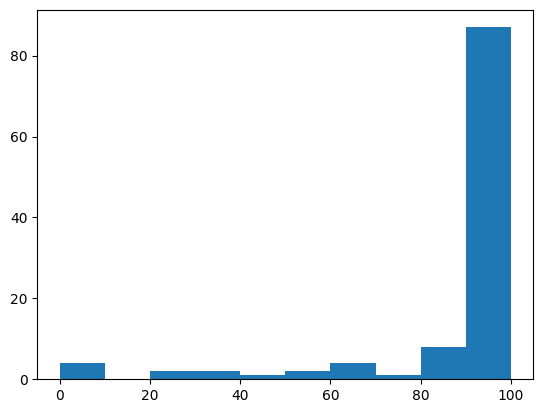

In [24]:
m = []

for id in main_df['id'].unique():
    m.append((main_df[main_df['id'] == id].shape[0] / 74) * 100)

m = np.array(m)
plt.hist(m)

In [25]:
len(m[m == 100.0])

49

In [26]:
len(m[m > 80])

95

<AxesSubplot: xlabel='time'>

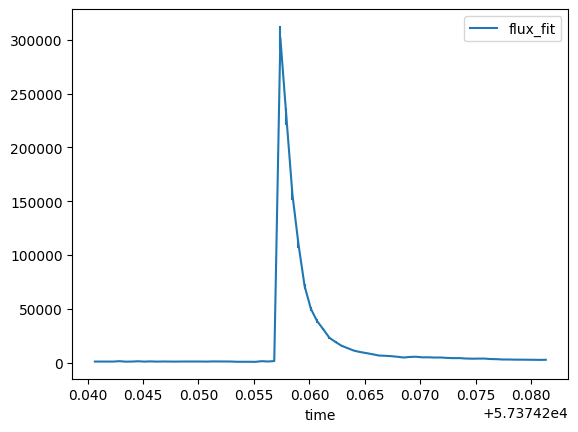

In [27]:
main_df[main_df['id'] == flr_id].plot(x = 'time', y='flux_fit', yerr='flux_err')

In [28]:
t_index = []

for i , time in enumerate(main_df['time'].dropna().unique()):

    if (main_df['time'][main_df['id'] == flr_id].values == time).any():
        t_index.append(True)

    else:
        t_index.append(False) 

In [29]:
len(t_index)

74

In [30]:
g_flux = main_df[main_df['id'] == flr_id]['flux_fit']
g_flux_err = main_df[main_df['id'] == flr_id]['flux_err']
flr_times = main_df[main_df['id'] == flr_id]['time']
g_mag = 22.5 - 2.5 * np.log10(g_flux.values)
g_mag_err = (2.5/np.log(10)) * (g_flux_err/g_flux)
g_mag_err = g_mag_err.values
delta_g_mag = g_mag - np.mean(g_mag[((flr_times - flr_times.iloc[0]) * 3600 * 24) < 1000])
delta_g_mag_err = g_mag_err - np.sqrt(np.sum(g_mag_err[((flr_times - flr_times.iloc[0]) * 3600 * 24) < 1000] ** 2)) /  len(g_mag_err[((flr_times - flr_times.iloc[0]) * 3600 * 24) < 1000])


for i, t in enumerate(t_index):
    if not t:
        delta_g_mag = np.insert(delta_g_mag, i, np.nan)
        delta_g_mag_err = np.insert(delta_g_mag_err, i, np.nan)
    else:
        pass

delta_g_mag, delta_g_mag_err

(array([ 4.50540586e-02,             nan,             nan,  6.18003671e-02,
        -2.75031746e-01,  1.53599598e-01,  5.28521951e-02, -2.06404632e-01,
         9.97016979e-02, -1.09199890e-01,  9.59371004e-02, -1.93514136e-02,
                    nan,  1.02343554e-01,  1.59777841e-02,             nan,
                    nan,  5.61083883e-03,  1.00573270e-01, -7.53870994e-02,
        -4.80756832e-02, -1.78392940e-02,  1.22433058e-02,  2.76158036e-01,
                    nan,  2.72314214e-01,  3.80101782e-01, -2.86631927e-01,
         1.46376557e-03, -3.65414442e-01, -6.12486939e+00, -5.82499183e+00,
        -5.41354601e+00, -5.03078173e+00, -4.55342130e+00, -4.17228568e+00,
        -3.89542434e+00, -3.66042475e+00, -3.33475428e+00, -3.13259622e+00,
        -2.91099073e+00, -2.74375166e+00, -2.54332689e+00, -2.41273437e+00,
        -2.29597276e+00, -2.15847218e+00, -1.98008144e+00, -1.94049208e+00,
        -1.87694650e+00, -1.77485261e+00, -1.62054447e+00, -1.73878246e+00,
        -1.7

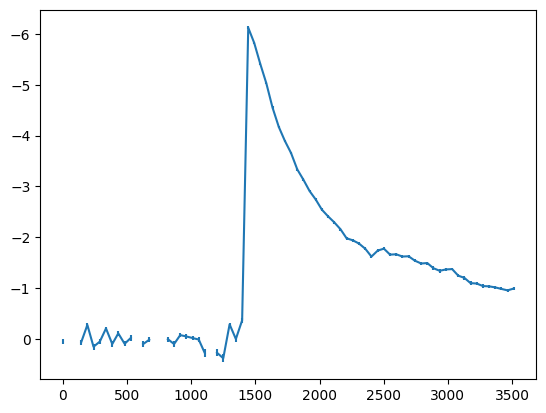

In [31]:
plt.errorbar((times - times[0]) * 3600 * 24, delta_g_mag, yerr=delta_g_mag_err)
plt.gca().invert_yaxis()

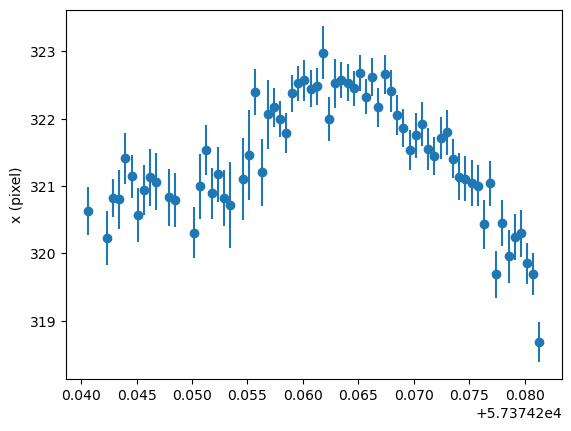

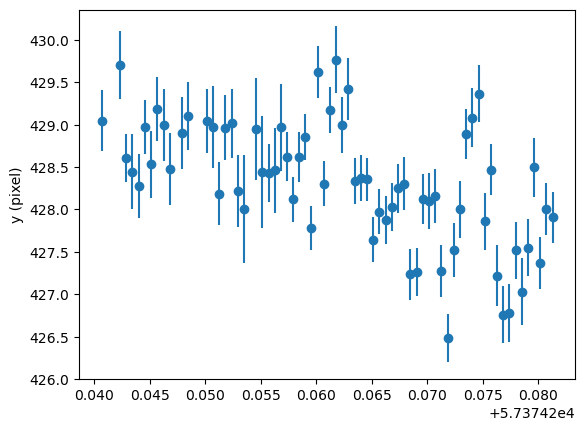

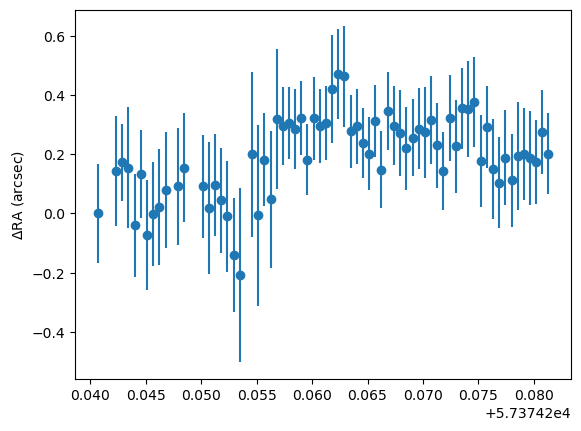

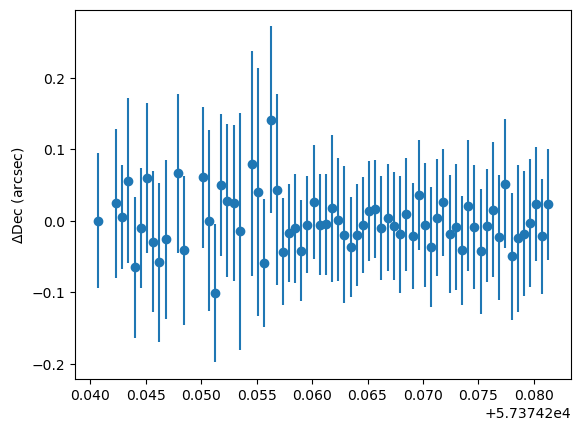

In [14]:
plt.errorbar(main_df['time'][main_df['id'] == flr_id], main_df['x_fit'][main_df['id'] == flr_id], yerr = main_df['x_err'][main_df['id'] == flr_id], marker='o', ls='None')
plt.ylabel('x (pixel)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], main_df['y_fit'][main_df['id'] == flr_id], yerr = main_df['y_err'][main_df['id'] == flr_id], marker='o', ls='None')
plt.ylabel('y (pixel)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], (main_df['RA'][main_df['id'] == flr_id] - main_df['RA'][main_df['id'] == flr_id].iloc[0]) * 3600, yerr = main_df['RA_ERR'][main_df['id'] == 11] * 3600, marker='o', ls='None')
plt.ylabel(r'$\Delta$RA (arcsec)')
plt.show()

plt.errorbar(main_df['time'][main_df['id'] == flr_id], (main_df['DEC'][main_df['id'] == flr_id] - main_df['DEC'][main_df['id'] == flr_id].iloc[0]) * 3600, yerr = main_df['DEC_ERR'][main_df['id'] == 11] * 3600, marker='o', ls='None')
plt.ylabel(r'$\Delta$Dec (arcsec)')
plt.show()